In [1]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import CubicSpline

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 3

In [2]:
R = 1.5
H = 6

In [3]:
dt = 3.6
dx = 2.2e-2

t0 = 0*3600
tf = 4*3600
xf = H

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

dx = x[1] - x[0]
# dt = t[1] - t[0]

Nx = len(x) - 1
Nt = len(t) - 1

In [4]:
Tmin = 290 + 273
Tmax = 396 + 273
eps = 0.22

In [5]:
Tavg = 0.5*(Tmax + Tmin) - 273

rhof = 2090 - 0.636*Tavg
muf = 0.0021 #(22.174 - 0.12*Tavg + 2.281e-4*Tavg**2 - 1.474e-7*Tavg**3)/1000
cpf = 1443 + 0.172*Tavg
kf = 0.443 + 0.00019*Tavg

d = 0.015
mDot = 7.0
u = mDot/(rhof*eps*np.pi*R**2)

rhos = 2500
cps = 830
ks = 5.69

In [6]:
CFL = dt*u/dx
CFL

0.3935059292030513

In [7]:
s0h = np.loadtxt('./Sandia_0h.csv', delimiter=";", dtype=float)
T0p = s0h[:,1] + 273
x0p = s0h[:,0]

s0hexp = np.loadtxt('./Sandia_0hexp.csv', delimiter=";", dtype=float)
T0pexp = s0hexp[:,1] + 273
x0pexp = s0hexp[:,0]

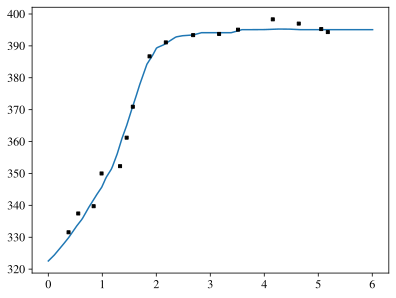

In [8]:
f = interpolate.interp1d(x0p, T0p, fill_value="extrapolate")

T0 = f(x)

plt.plot(x, T0-273, x0pexp, T0pexp - 273, 'ks')
plt.show()

In [9]:
Tin = Tmin

Tf = np.zeros((Nt+1, Nx+1))
Ts = np.zeros((Nt+1, Nx+1))

# BCs
Tf[:,0] = Tin

# ICs
Tf[0,:] = T0
Ts[0,:] = T0

In [10]:
rChar = eps*d/(4*(1-eps))
G = mDot/(eps*np.pi*R**2)
Re = 4*G*rChar/muf
Pr = cpf*muf/kf

Sr = 2*3*np.pi*R**2*(1 - eps)/d

h = 0.191*mDot*cpf/(eps*np.pi*R**2)*Re**(-0.278)*Pr**(-2/3)

In [11]:
alpha = eps*rhof*cpf
beta = eps*kf
gamma = (1-eps)*rhos*cps
betas = ks*(1 - eps)

Rep = rhof*d*u/muf
Pr = cpf*muf/kf
Nu = 0.664*Rep**0.5*Pr**0.5
a = Nu*kf/d
#h = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(d**2)

h = a*6*(1-eps)/d

p = dt*u/dx
q = 2*beta/alpha*0.5*dt/(dx**2)
r = h*dt/alpha

rs = dt*h/gamma
qs = 2*betas*0.5*dt/(gamma*dx**2)

In [12]:
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]
offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p

A = sp.sparse.csr_matrix(A)
# A_inv = sp.sparse.linalg.inv(A)

In [13]:
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]
offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)
# As_inv = sp.sparse.linalg.inv(As)

In [14]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
bc1[0] = Tin

In [15]:
for i in range(1,Nt+1):
    
    bc0 = np.zeros(Nx)
    bc1 = np.zeros(Nx)

    bc0[0] = Tin
    bc1[0] = Tin

    Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i-1,:])

    Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
                r*Ts[i-1,1:])


In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(x, t/3600, Tf - 273, 16)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T_f$ ($^\circ$ C)', fontsize=16)
ax1.set_ylabel(r'$t$ (h)')
ax1.set_box_aspect(1)
# ax1.set_xlim([0, 6])

cs2 = ax2.contourf(x, t/3600, Ts - 273, 16)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$ ($^\circ$ C)', fontsize=16)
ax2.set_xlabel(r'$y$ (m)')
ax2.set_ylabel(r'$t$ (h)')
ax2.set_box_aspect(1)
# ax2.set_xlim([0, 6])


# plt.colorbar()
# plt.xlim([0, 0.05])
# plt.ylim([0, 10])
plt.savefig('T_vs_x_t.pdf')

plt.show()

In [17]:
dt0 = 0.10

nt0h = int(0*3600/dt)
nt0p5h = int((0.5 + dt0 )*3600/dt)
nt1h = int((1.0 + dt0)*3600/dt)
nt1p5h = int((1.5 + dt0)*3600/dt)
nt2h = int((2.0 + dt0)*3600/dt)

In [18]:
s0hexp = np.loadtxt('./Sandia_0hexp.csv', delimiter=";", dtype=float)
s0p5h = np.loadtxt('./Sandia_0p5h.csv', delimiter=";", dtype=float)
s1h = np.loadtxt('./Sandia_1h.csv', delimiter=";", dtype=float)
s1p5h = np.loadtxt('./Sandia_1p5h.csv', delimiter=";", dtype=float)
s2h = np.loadtxt('./Sandia_2h.csv', delimiter=";", dtype=float)

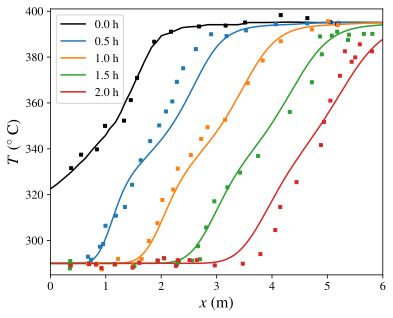

In [24]:
fig, ax = plt.subplots()
plt.plot(x, Tf[nt0h,:] - 273, 'k', x, Tf[nt0p5h,:] - 273, x, \
         Tf[nt1h,:] - 273, x, Tf[nt1p5h,:] - 273, x, Tf[nt2h,:] - 273)

plt.gca().set_prop_cycle(None)

plt.plot(s0hexp[:,0], s0hexp[:,1], 'ks', s0p5h[:,0], s0p5h[:,1], 's', \
         s1h[:,0], s1h[:,1], 's', s1p5h[:,0], s1p5h[:,1], 's', s2h[:,0], s2h[:,1], 's')

plt.ylim([Tmin-5-273, Tmax+5-273])
plt.xlim([0, 6])
plt.legend([r'0.0 h', r'0.5 h', r'1.0 h', r'1.5 h', r'2.0 h'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$T$ ($^\circ$ C)')
plt.savefig('validation_T_vs_x.pdf')
plt.show()